In [1]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt
from astrodendro import Dendrogram

import constants as c
from aRead import readAREPO, readSinks, readImage

In [9]:
# Start using my matplotlib style sheet
plt.style.use("mattStyle")

In [6]:
# Open the files we want
#uv1 = readAREPO("/scratch/c.c1922522/bigClouds/UV1/cloudUV1_160.hdf5", 1)
#uv1000 = readAREPO("/scratch/c.c1922522/bigClouds/UV1000/cloudUV1000_160.hdf5", 1)
#uv1cr = readAREPO("/scratch/c.c1922522/bigClouds/UV1crAtt/cloudUV1_080.hdf5", 1)
#uv1000cr = readAREPO("/scratch/c.c1922522/bigClouds/UV1000crAtt/cloudUV1000_080.hdf5", 1)

uv1s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1/sink_snap_098")
uv1000s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000/sink_snap_087")
uv1crs = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1crAtt/sink_snap_089")
uv1000crs = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000crAtt/sink_snap_087")

print(np.sum(uv1crs.sinkMass), np.sum(uv1000crs.sinkMass))

460.24646698779037 443.67476062962373


### Temperature-Density Diagrams

In [8]:
# Function to bin and average the temperatures
def binTemperatureDensity(temperature, dust, density, mass, binNum=50):
    # Log density and work out bins
    numDense = np.log10(density)
    densityBins = np.linspace(np.min(numDense), np.max(numDense), binNum)

    # Arrays to store values
    gasTemp = np.zeros(binNum-1)
    dustTemp = np.zeros(binNum-1)
    densityMid = np.zeros(binNum-1)

    # Loop through bins and average
    for i in range(binNum-1):
        # Getting our bin ranges
        binMin = densityBins[i]
        binMax = densityBins[i+1]

        # Finding gas and temperture particles in this bin
        ind = np.where((numDense <= binMax) & (numDense >= binMin))    

        # Assigning avearage gas temperature and density
        gasTemp[i] = np.average(np.log10(temperature[ind]), weights=mass[ind])
        dustTemp[i] = np.average(np.log10(dust[ind]), weights=mass[ind])
        densityMid[i] = (binMax + binMin) / 2

    return densityMid, gasTemp, dustTemp

In [11]:
# Bin the data
n1, t1, d1 = binTemperatureDensity(uv1.gasTemp, uv1.dustTemp, uv1.numberDensity, uv1.mass)
n1cr, t1cr, d1cr = binTemperatureDensity(uv1cr.gasTemp, uv1cr.dustTemp, uv1cr.numberDensity, uv1cr.mass)

n1000, t1000, d1000 = binTemperatureDensity(uv1000.gasTemp, uv1000.dustTemp, uv1000.numberDensity, uv1000.mass)
n1000cr, t1000cr, d1000cr = binTemperatureDensity(uv1000cr.gasTemp, uv1000cr.dustTemp, uv1000cr.numberDensity, uv1000cr.mass)

Text(0, 0.5, 'Temperature [K]')

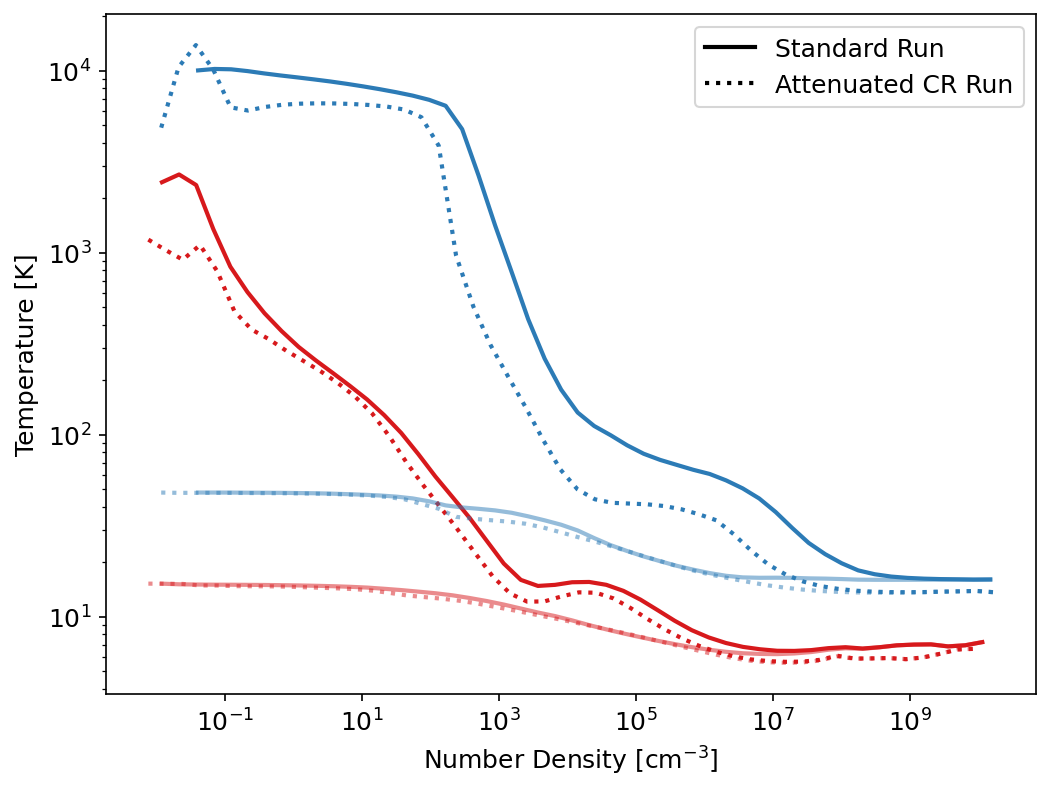

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(10**n1, 10**t1, c.colours()[0])
ax.plot(10**n1cr, 10**t1cr, c.colours()[0], linestyle=":")
ax.plot(10**n1, 10**d1, c.colours()[0], alpha=0.5)
ax.plot(10**n1cr, 10**d1cr, c.colours()[0], linestyle=":", alpha=0.5)

ax.plot(10**n1000, 10**t1000, c.colours()[4])
ax.plot(10**n1000cr, 10**t1000cr, c.colours()[4], linestyle=":")
ax.plot(10**n1000, 10**d1000, c.colours()[4], alpha=0.5)
ax.plot(10**n1000cr, 10**d1000cr, c.colours()[4], linestyle=":", alpha=0.5)

# Dummy data for legend
ax.plot(0,10, "k", label="Standard Run")
ax.plot(0,10, "k:", label="Attenuated CR Run")

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number Density [$\\rm cm^{-3}$]")
ax.set_ylabel("Temperature [K]")

### Core Mass Function

In [4]:
def coreMassFunction(imagePath, minVal=22.3, minPix=10, minDelta=0.09):
    # Load in the image data
    image = readImage(imagePath)
    
    # Create the grid and column density map
    columnGrid = image.image * image.umass_g / (1.4*c.mProt()*image.ulength_cm**2)

    # Find the pixel size
    #pixSize = (image.x1-image.x0) * (image.y1-image.y0) * image.ulength_cm**2 / (image.nx*image.ny)
    pixSize = 2.4414062499999997e+32

    # Create the dendrogram
    dendro = Dendrogram.compute(np.log10(columnGrid), min_value=minVal, min_npix=minPix, min_delta=minDelta)

    # Calculate the CMF 
    masses = np.zeros(len(dendro.leaves))
    for i in range(len(dendro.leaves)):
        pixVals = 10**dendro.leaves[i].values() * 1.4 * c.mProt() * pixSize

        masses[i] = np.sum(pixVals) / c.uMass()

    return masses

In [5]:
# Work out the core mass functions
m1 = coreMassFunction("/home/c.c1922522/apricot/CMFimages3/column_cloudUV1_041.dat")
m1cr = coreMassFunction("/scratch/c.c1922522/bigClouds/UV1crAtt/column_cloudUV1_040.dat")

m1000 = coreMassFunction("/home/c.c1922522/apricot/CMFimages3/column_cloudUV1000_072.dat")
m1000cr = coreMassFunction("/scratch/c.c1922522/bigClouds/UV1000crAtt/column_cloudUV1000_065.dat")

Text(0, 0.5, 'Number of Cores')

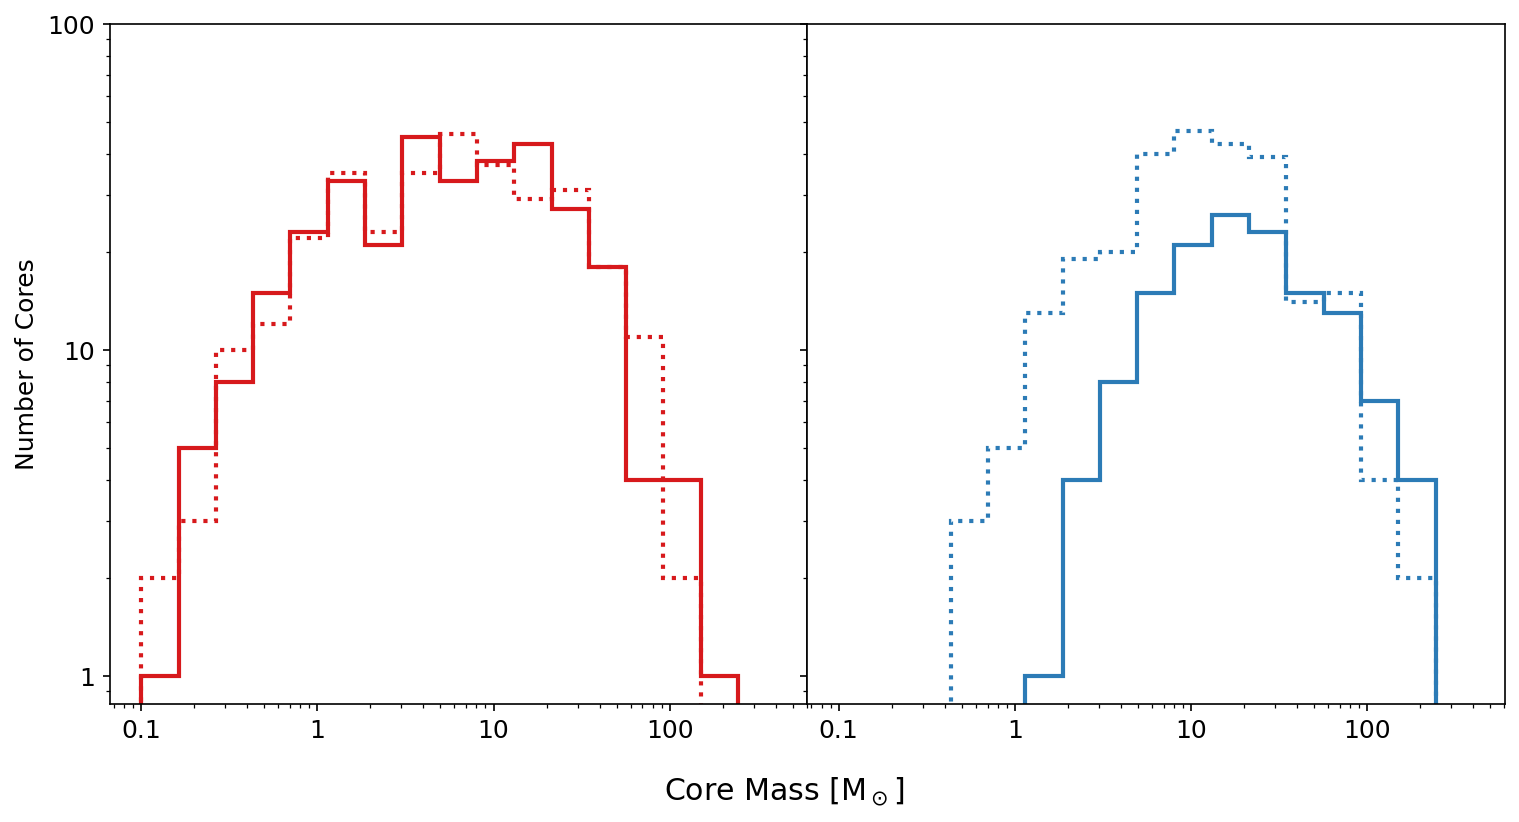

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12, 6), sharex=True, sharey=True)

bins = 10**np.linspace(-1, 2.6, 18)

axs[0].hist(m1, bins=bins, color=c.colours()[0], histtype="step", linewidth=2)
axs[0].hist(m1cr, bins=bins, color=c.colours()[0], histtype="step", linestyle=":", linewidth=2)

axs[1].hist(m1000, bins=bins, color=c.colours()[4], histtype="step", linewidth=2)
axs[1].hist(m1000cr, bins=bins, color=c.colours()[4], histtype="step", linestyle=":", linewidth=2)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].set_xticks([1e-1, 1e0, 1e1, 1e2])
axs[0].set_xticklabels(["0.1", "1", "10", "100"])
axs[0].set_yticks([1, 10, 100])
axs[0].set_yticklabels([1, 10, 100])

fig.supxlabel("Core Mass [$\\rm M_\\odot$]")
axs[0].set_ylabel("Number of Cores")

### Sink Mass Function

Text(0.06, 0.5, 'Number of Sinks')

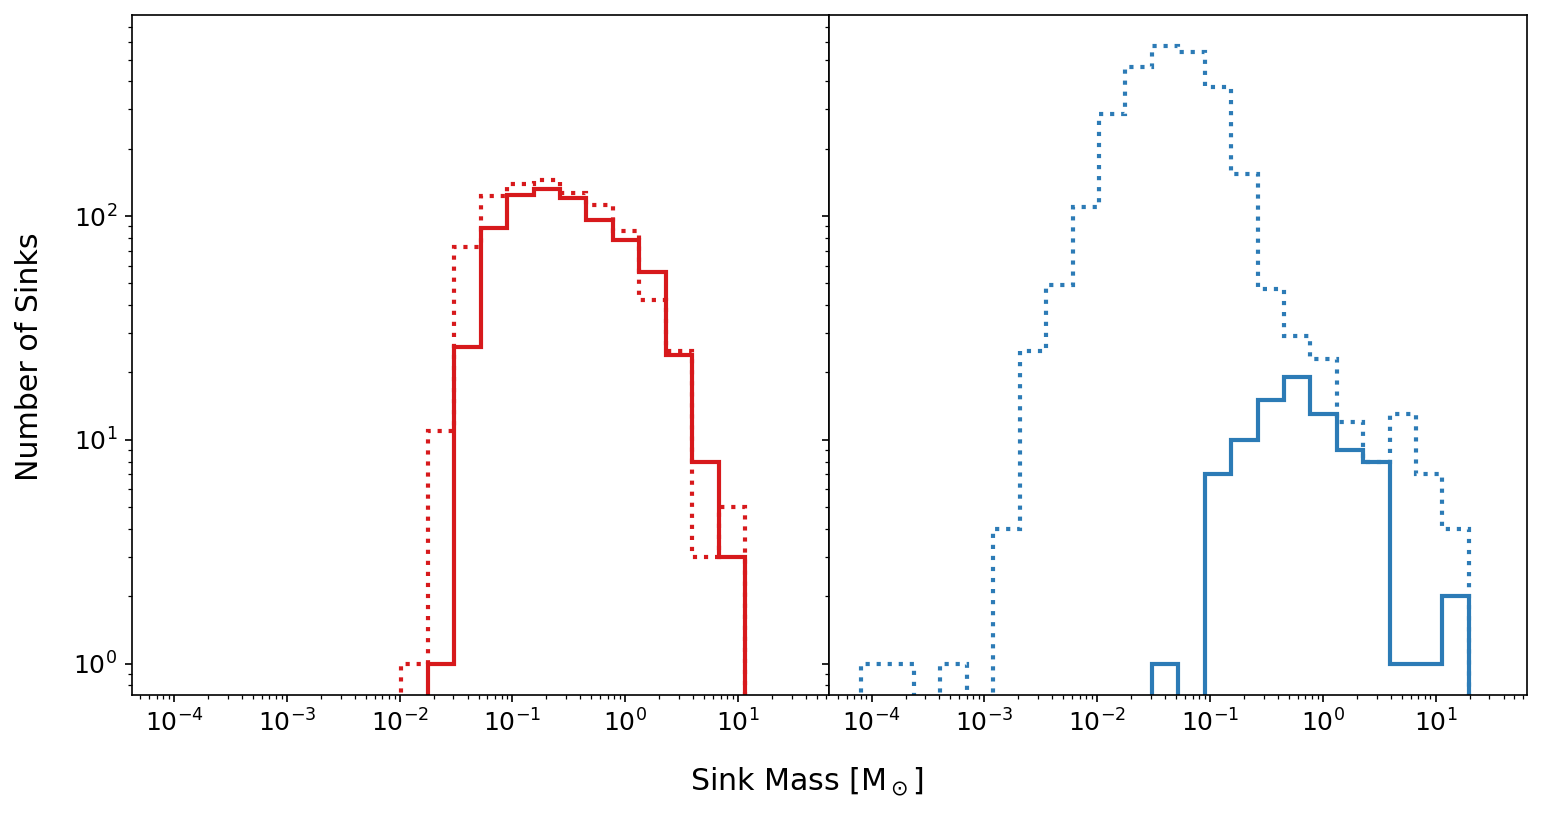

In [10]:
# Create the bins to plot against
bins = 10**np.linspace(np.min(np.log10(uv1000crs.sinkMass)), np.max(np.log10(uv1000s.sinkMass)), 25)

fig, axs = plt.subplots(1,2, figsize=(12, 6), sharex=True, sharey=True)

axs[0].hist(uv1s.sinkMass, bins=bins, histtype="step", color=c.colours()[0], linewidth=2)
axs[0].hist(uv1crs.sinkMass, bins=bins, histtype="step", color=c.colours()[0], linestyle=":", linewidth=2)

axs[1].hist(uv1000s.sinkMass, bins=bins, histtype="step", color=c.colours()[4], linewidth=2)
axs[1].hist(uv1000crs.sinkMass, bins=bins, histtype="step", color=c.colours()[4], linestyle=":", linewidth=2)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

fig.supxlabel("Sink Mass [$\\rm M_\\odot$]")
fig.supylabel("Number of Sinks", x=0.06)

In [13]:
sData = readSinks(4, "/scratch/c.c1922522/bigClouds/UV1crAtt/sink_particle_info/")
sData2 = readSinks(4, "/scratch/c.c1922522/bigClouds/UV1000crAtt/sink_particle_info/")

Text(0, 0.5, 'Total Sink Mass')

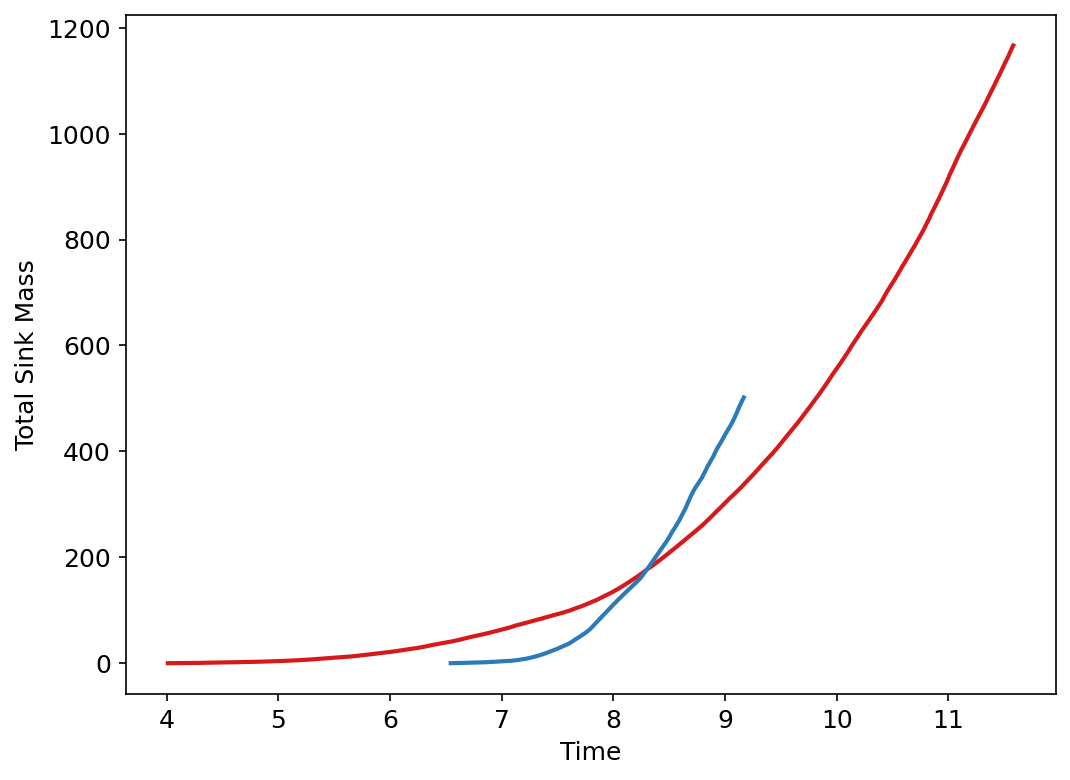

In [18]:
plt.plot(sData.time, np.sum(sData.sinkMass, axis=1), c.colours()[0])
plt.plot(sData2.time, np.sum(sData2.sinkMass, axis=1), c.colours()[4])
plt.xlabel("Time")
plt.ylabel("Total Sink Mass")